# The Path of Optimization

In the previous notebook we used the ability to freeze coordinates and set variables in a molecule object to create a scan of energy vs bend angle in water. That was very much a modelling of the vibration for the bending in the water molecule. What if we want to model something more similar to a reaction. A change that starts in one stable form and ends in another stable form. A bond rotation is an example of this.

First we must build and optimize a molecule and then set it up so that we can change and freeze a given coordinate (distance, bend or dihedral).

## Build and Optimize Butane

Coordinates for butane are available or I could build it in Avogadro and then export the coordinates to a text file for including in my input text string. However, for educational purposes I will build the geometry manually using a Z-matrix. I will construct it as follows...

- I will imagine a carbon attached to a second carbon. (Lines 1 and 2)
- I will then add three hydrogens to one of the carbons at bond angles and dihedrals that describe a methyl group. (lines 3,4 & 5)
- The add a third carbon (line 6)
- Add two hydrogens to the second carbon (lines 7 & 8)
- Add a fourth carbon. The dihedral angle will be defined along the carbons \#1, 2, 6 and 9. (line 9)
- Add two hydrogens to the third carbon (lines 10 & 11)
- Finally, add three hydrogens to the fourth carbon (lines 12, 13 & 14)

Examine the Z-matrix in the code below and convince yourself that we did it right. There are many ways to accomplish the same structure in the Z-matrix format. Don't be afariad to improve on my efforts.

In [1]:
# use psi4conda environment
import psi4

import os
import numpy as np
import matplotlib.pyplot as plt

import helpers as hp # Many useful functions from https://lcbc-epfl.github.io/iesm-public/intro.html

output_file = "butane_1.out"
psi4.set_memory("1GB")
psi4.set_output_file(output_file, append=False, loglevel=20, print_header=True, inherit_loglevel=True, execute=True)
psi4.core.set_num_threads(4)

# The Z-matrix as a text string
data = """
       0 1
       C1
       C2  1  1.5
       H11 1  1.0  2  109.0
       H12 1  1.0  2  109.0  3  120
       H13 1  1.0  2  109.0  3 -120
       C3  2  1.5  1  109.0  3  60
       H21 2  1.0  1  109.0  6  120
       H22 2  1.0  1  109.0  6 -120
       C4  6  1.5  2  109.0  1  dihedral
       H31 6  1.0  2  109.0  9  120
       H32 6  1.0  2  109.0  9 -120
       H41 9  1.0  6  109.0  10  0
       H42 9  1.0  6  109.0  10  120
       H43 9  1.0  6  109.0  10  -120

       dihedral = 175
       units angstrom
       """ 

# Create the Molecule object
mol = psi4.geometry(data)             # Create Molecule object from data string


  Memory set to 953.674 MiB by Python driver.


In [2]:
help(psi4.core.IOManager.set_default_path)

Help on instancemethod in module psi4.core:

set_default_path(...)
    set_default_path(self: psi4.core.IOManager, path: str) -> None
    
    Set the default path for files to be stored



### Check the Structure

I in fact goofed up several times while editting the Z-matrix above. I was constantly checking my work as I moved along by visualizing the molecule using the code below. Others wrote the ```hp.drawXYZ_labeled()``` function that I used. Always steal code, never reinvent the wheel.

Spin it around in the window below with your mouse. How does it look? The number labels are numbered in the *Python* fashions starting at "0". The numbering in the Z-matrix starts at "1". So atom \#0 in the image below is atom \#1 in the Z-matrix. What can I say, thats *Python* for you. Perhaps I should edit the code in ```hp.drawXYZ_labeled()``` to fix it? Or maybe I just don't care enough.

Change the dihedral value in the Z-matrix and confirm that it smoothly rotates a single bond and nothing goes crazy.

In [3]:
hp.drawXYZ_labeled(mol)  # This command from the 'helpers' library will display the molecule
                         # Does it look like what you expect?

#hp.drawXYZ(mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Optimize the Structure

We used the "cc-pvdz" basis set for our calculations in water. Water has three atoms and it is described in the cc-pvdz basis set by 24 functions (5 for H and 14 for O) \[[wikipedia](https://en.wikipedia.org/wiki/Basis_set_(chemistry))\]. Butane has 14 atoms and is described by 106 basis functions. Computational effort using Hartree-Fock methodology scales at $n^3$ \[[wikipedia](https://en.wikipedia.org/wiki/Ab_initio_quantum_chemistry_methods)\]. We have about 380 times the effort required for butane compared to water. So its going to take a lot of computer effort, even with this small molecule. 

The minimal "STO-3G" basis set uses one function for hydrogen and 5 for carbon and oxygen. Thus butane has 30 basis function comapred to 106 with "cc-pvdz". The computation effort will be 44 times less. What took 400 seconds with the larger basis set will take about 10 seconds with the minimal basis set. It will be less accurate but much faster. I'm not getting any younger.

My first effort at optimization took over 4 minutes to complete. I can take that time when I am on my own. For this class demonstration we will drop down to the "STO-3G" basis set. With "STO-3G" the code below completed the optimization in 10 seconds. We now have an optimized structure. 

In [4]:
psi4.set_options({
        "BASIS": "sto-3g",            # default => None - Basis set must be specified
#        "BASIS": "6-31+G(d)",            # default => None - Basis set must be specified
        "SAVE_OPTIMIZATION": True,    # default => False
        "OPT_TYPE": "min",            # default => "min":  "min","irc" or "ts"
        "MAXITER": 100,               # default => 50
        "GEOM_MAXITER": 100,          # default => 50
        "FULL_HESS_EVERY": -1,        # default => -1 -> -1 is "off"; 0 will perform a calculation at the beginning
        "PRINT": 2,                   # default => 1
        "GUESS": "sad",               # default => auto
        "REFERENCE": "rhf",           # default => rhf
        "SCF_TYPE": "direct",         # default => pk
        "INTS_TOLERANCE": 1E-8,       # default => 1e-12. A value of 1e-8 is recommended when SCF_TYPE set to "direct"
        "PRINT_TRAJECTORY_XYZ_FILE":True,   # default => false
        "PRINT_OPT_PARAMS": True,     # default => False
        "WRITE_TRAJECTORY": True      # default => False
    })

start_angle = mol.get_variable("dihedral")
print(f"Before optimization: {start_angle:.3f} degrees\n") 


opt_energy, hist = psi4.optimize("hf", molecule = mol, return_history=True)
print(f"The optimized energy for this configuration is {opt_energy:.7f} Hartree\n")

mol.print_out()
mol.print_distances()
mol.print_bond_angles()
mol.print_in_input_format()

dihedral_angle = mol.get_variable("dihedral")
#opt_length = mol.get_variable("length")

print(f"After optimization: {dihedral_angle:.3f} degrees\n") 

Before optimization: 175.000 degrees

Optimizer: Optimization complete!
The optimized energy for this configuration is -155.4666462 Hartree

After optimization: -179.996 degrees



### The Path to Perfect

Optimization is done by calculating the derivative of the energy function and then moving the atoms along the directions that take that function "downhill." Sometimes the change can be "bad." Consider the energies of each structure that was tried by the optimizer as we approached the optimized geometry. These values were collected in the dictionary named "```hist```". I will print them out below as relative values w.r.t. the final energy value. 

You can see that the energy was moving toward a minimum and then the optimization took a very bad turn. But it kept going and found a structure that had settled to an energy minimum. Sometimes that bad move can blow up the whole calculation and you may need to tweek the starting geometry. out initial geometry used very crude values for the bond lengths. Perhaps that is why we had this wild ride?

In [5]:
a = np.array(hist["energy"])
b = ((a - a[-1]) * psi4.constants.hartree2kJmol)
for c in b: print(f"{c:10.3f}")

   226.261
    17.126
    13.050
    12.835
    12.809
    12.786
   171.376
    50.581
    13.832
    12.366
   407.623
   223.402
    33.331
    11.519
     9.566
     7.076
     3.152
     4.220
     0.241
     0.025
     0.004
     0.000
     0.000


### Trust Your Eyes

We should always eyeball the final structure. We might have found a local minimum (e.g. the gauche confromer) rather than the global minimum (the "anti" conformer). Move the molecule around with your mouse and reassure yourself that the structure is reasonable.

In [6]:
hp.drawXYZ(mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Trust the Numbers

We can also print the geometry out and check the bond lengths and angles. The ```Molecule``` object has a method called ```print_in_input_format()``` that will print the geometry in the format used in the input string. In this case it was a Z-matrix, which is easier to interpret compared to cartesian coordinates. I will start a new input file to capture this output and then I will write it into ```stdout``` so that it appears below.

In [7]:
psi4.set_output_file("temp.dat", append=False, print_header=False)
mol.print_in_input_format()
!cat "temp.dat"     # cat is a terminal command that will print the contents of a file to stdout

    Molecular point group: c1
    Full point group: C1

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

    C       
    C             1    1.541123
    H             1    1.086007      2  110.745736
    H             1    1.086015      2  110.605005      3  119.995685
    H             1    1.086008      2  110.745075      3 -120.008854
    C             2    1.544996      1  112.451029      3   60.014774
    H             2    1.088522      1  109.314659      6  121.514536
    H             2    1.088524      1  109.311244      6 -121.513487
    C             6    1.541081      2  112.452832      1    dihedral
    H             6    1.088515      2  109.245176      9  121.545777
    H             6    1.088517      2  109.246257      9 -121.561687
    H             9    1.086006      6  110.748082     10  -61.500255
    H             9    1.086014      6  110.612183     10   58.497890
    H             9    1.086009      6  110.739376     10  178.492566

    dihedral  = -1

## Digging Deeper

Data analysis is the core of science. What we observe leads to our discoveries, great and small. In this case we observed a somewhat chaotic journey from the starting structure to the lowest energy optimized geometry. 

### Visualizing the Data

We checked that the final structure made sense and it did. We observe reasonable values for bond lengths, bends and dihedral angles. I must admit, the dihedral angles in the last three lines of the Z-matrix above intrigued me. I would have expected values of 60, 120 and -120. Instead I see -60, +60 and 180 degrees. These values are all 120 degree apart and so fit the expected structure of a methyl group and yet I somehow feel something isn't as expected.

First let us visualize the energies with each step of the optimization. the code below will plot the energy values collected in the ```hist``` dictionary that was created by the ```psi4.optimize()``` function above.

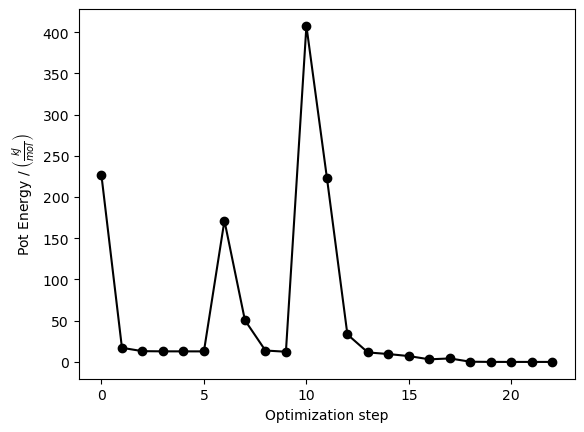

In [8]:

fig, ax =  plt.subplots(1)                     # Create a blank plot in a figure

energies = np.array(hist["energy"])           # Get the list of energies from the history of the optimization
energies = (energies - energies[-1]) * psi4.constants.hartree2kJmol   # relative energy in kJ/mole

ax.plot(energies, "ko-")
ax.set_xlabel('Optimization step')
ax.set_ylabel(r'Pot Energy /$\;\left(\frac{kJ}{mol}\right)$')

plt.show()

### Visualizing the Journey

There are two enormous excusions in the path to the optimized structure. this hints that my initial structure did not provide an easy path to the most stable conformer.

The expected steric strain between the eclipsed and anti conformations of butane is about 20 $\frac{kJ}{mol}$. After the initial relaxation with optimization of bond lengths we should have been left with minor tweeks to get to the final structure. Instead we see large energy jumps as the algorithm thrashed in frustration. It may be instructive to visualize all the geometries along the path to optimization.

These geometries are stores as matrixes of xyz coordinates in the "```coordinates```" key of the ```hist``` object returned from the ```psi4.optimization()``` function. These coordinates lack the atom albels but each line corresponds to the lines of the input data. We can convert these to sets of input data in the cartesian coordinate format by appending a column of atom labels. The ```mol2traj()``` function in the ```helpers``` package written by Ursula Roethlisberger and Andrej Antalík of the École Polytechnique Fédérale de Lausanne will do this for us. Always steal code that has already been written. And always give credit.

Move the slider in the image below and follow the progress of the optimization. You will see that one of the methyl groups (carbon 9) starts off in perfect eclipsed arrangement with the adjacent carbon group. The gradient at the top of a curve is zero, just like at the bottom. So the atoms are not displaced left or right by the optimization driver; instead the system thrashes and makes poor choice in changing bond lengths. That is why we see the large jumps in energy.

Eventually there must be some part of the algorith that tries random movements of atoms or some other scheme that pushes the eclipsed arrangement just slightly away from perfect opposition.  Once the slope downhill to the anti conformer is revealed, the algorithm eventually follows it to the energy well we expected.

In [9]:
coordinates = hist["coordinates"]
traj = hp.mol2traj(mol, coordinates)

hp.drawXYZGeomSlider(traj)

interactive(children=(IntSlider(value=0, description='conf', max=22), Output()), _dom_classes=('widget-interac…

## Correcting the Error

I had made an error in setting up the original Z-matrix. Despite visualizing the structure, I did not notice the eclipsed group. Go back up and look. You will see it now. How did we miss it? You were in the room too, so its not all on me.

### Changing the Input

Quite often a teh problem with a calculation is the input. Here we started with a problemativ structure at the very top of an energy peak for one of the bond rotations. The system couldn't see a way out when the derivative for that particular compnent of the energy was zero (the slope at the top of a curve is zero). Sometimes all you need to do is tweak a value to get us to the slope that leads to "down". In this case we know exactly wher the problem was. Sometimes I just cahge all the values in the structure by 1\% and that fixes the problem. 

Let us now correct the Z-matrix. The code below will create the geometry that I had intended at the beginning.  Look to the last three lines for the changes. Do you see how I made the initial error? I cut-and-pasted code for the blocks above and the code below will declare the initial geometry, optimize it and then output the energy plot and the structures at each step. You wil see that it will take far fewer steps now that we are beginning closer to the target geometry.

Before optimization: 175.000 degrees

Optimizer: Optimization complete!
The optimized energy for this configuration is -155.4666462 Hartree

After optimization: 179.941 degrees



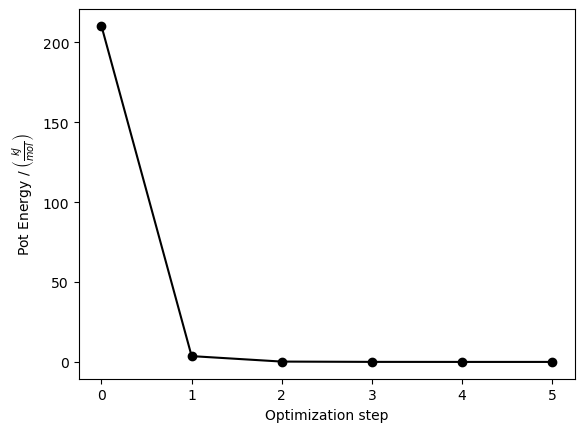

interactive(children=(IntSlider(value=0, description='conf', max=5), Output()), _dom_classes=('widget-interact…

In [10]:
output_file = "butane_2.out"
psi4.set_memory("1GB")
psi4.set_output_file(output_file, append=False, loglevel=20, print_header=True, inherit_loglevel=True, execute=True)
psi4.core.set_num_threads(4)

# The Z-matrix as a text string
data = """
       0 1
       C1
       C2  1  1.5
       H11 1  1.0  2  109.0
       H12 1  1.0  2  109.0  3  120
       H13 1  1.0  2  109.0  3 -120
       C3  2  1.5  1  109.0  3  60
       H21 2  1.0  1  109.0  6  120
       H22 2  1.0  1  109.0  6 -120
       C4  6  1.5  2  109.0  1  dihedral
       H31 6  1.0  2  109.0  9  120
       H32 6  1.0  2  109.0  9 -120
       H41 9  1.0  6  109.0  10  60
       H42 9  1.0  6  109.0  12  120
       H43 9  1.0  6  109.0  12  -120

       dihedral = 175
       units angstrom
       """ 

# Create the Molecule object
mol = psi4.geometry(data)             # Create Molecule object from data string

start_angle = mol.get_variable("dihedral")
print(f"Before optimization: {start_angle:.3f} degrees\n") 

opt_energy, hist = psi4.optimize("hf", molecule = mol, return_history=True)
print(f"The optimized energy for this configuration is {opt_energy:.7f} Hartree\n")

mol.print_out()
mol.print_distances()
mol.print_bond_angles()
mol.print_in_input_format()

dihedral_angle = mol.get_variable("dihedral")
#opt_length = mol.get_variable("length")

print(f"After optimization: {dihedral_angle:.3f} degrees\n") 

fig, ax =  plt.subplots(1)                     # Create a blank plot in a figure

energies = np.array(hist["energy"])           # Get the list of energies from the history of the optimization
energies = (energies - energies[-1]) * psi4.constants.hartree2kJmol   # relative energy in kJ/mole

ax.plot(energies, "ko-")
ax.set_xlabel('Optimization step')
ax.set_ylabel(r'Pot Energy /$\;\left(\frac{kJ}{mol}\right)$')

plt.show()

coordinates = hist["coordinates"]
traj = hp.mol2traj(mol, coordinates)

hp.drawXYZGeomSlider(traj)

### 

## Conclusions

We have optimized butane in the strat of our effort to perform a scan of energy vs. torsion angle. Along the way we observed some issues that you need to be aware of as you build initial structure. We also demosntrated some more features of the ```helpers``` module written by Ursula Roethlisberger and Andrej Antalík. We displayed the molecule using ```helpers.drawXYZ``` and we deisplayed the molecule with atoms labels using ```helpers.drawXYZ_labeled(mol)```. We also collected history information from the ```psi4.optimize()``` function and used this information to plot the energies at each step using ```matplotlib```. We used ```helpers.mol2traj()``` to create a list of cartesian coordinates at each optimization step from the ```Molecule``` object and the ["coordinates"] list in the histpry dictionary. We then sent this list of structures into ```helpers.drawXYZGeomSlider()``` to be able to visualize the structure at each step.

## Preparing for the Next Step

Now that we have an optimized structure, I will capture the final Z-matrix as a text file. I will use this text as the initial structure in the next notebook where we will constrain the structure to the gauche and eclipsed forms to get the energy at the anticipated peaks and valleys of the energy coordinate with bond rotation.

The code below will save the Z-matrix that represents the optimizede structure as a text file and will capture that file in the output below so that we can more easily cut-and-paste it.

In [11]:
psi4.set_output_file("temp.dat", append=False, print_header=False)
mol.print_in_input_format()
!cat "temp.dat"     # cat is a terminal command that will print the contents of a file to stdout

    Molecular point group: c1
    Full point group: C1

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

    C       
    C             1    1.541090
    H             1    1.085997      2  110.737654
    H             1    1.086006      2  110.607207      3  119.996707
    H             1    1.085996      2  110.737537      3 -120.006541
    C             2    1.545066      1  112.446725      3   59.916254
    H             2    1.088519      1  109.298807      6  121.516910
    H             2    1.088518      1  109.301738      6 -121.519264
    C             6    1.541169      2  112.445221      1    dihedral
    H             6    1.088515      2  109.250918      9  121.551235
    H             6    1.088516      2  109.250874      9 -121.547269
    H             9    1.085998      6  110.604358     10   58.384210
    H             9    1.085992      6  110.745577     12  119.994957
    H             9    1.085994      6  110.746117     12 -119.995065

    dihedral  =  1

In [12]:
hp.drawXYZ(mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.